In [309]:
import numpy as np

# General Parameters
TIMESTEPS = 80  # Number of time steps (frames)
GRID_SIZE = 41  # Grid size (41x41 grid)
gray_background = 255  # Background gray value (255 means white)

# Function to generate moving and expanding shapes
def generate_moving_and_expanding_shapes():
    animations = {}

    # Generate expanding 10x10 square starting from the center
    expanding_images = np.ones((TIMESTEPS, GRID_SIZE, GRID_SIZE), dtype=np.uint8) * gray_background  # Initialize with white background
    center_x, center_y = GRID_SIZE // 2, GRID_SIZE // 2  # Center coordinates of the grid
    initial_size = 3  # Initial size of the square (3x3)

    for t in range(TIMESTEPS):
        half_size = initial_size // 2 + t  # Half of the square size at each time step
        start_x = max(0, center_x - half_size)  # Ensure the square stays within the grid bounds
        end_x = min(GRID_SIZE, center_x + half_size + 1)  # End of the square's x-coordinate
        start_y = max(0, center_y - half_size)  # Ensure the square stays within the grid bounds
        end_y = min(GRID_SIZE, center_y + half_size + 1)  # End of the square's y-coordinate
        expanding_images[t, start_y:end_y, start_x:end_x] = 0  # Set the square pixels to black (0)

    animations[(3, 3)] = expanding_images  # Add expanding square with key (3, 3)

    # Function to generate moving rectangles
    def generate_moving_rectangle(width, height):
        images = np.ones((TIMESTEPS, GRID_SIZE, GRID_SIZE), dtype=np.uint8) * gray_background  # Initialize with white background
        for t in range(TIMESTEPS):
            start_x = max(0, t - width)  # Ensure rectangle starts within bounds
            end_x = min(t, GRID_SIZE)  # Ensure rectangle ends within bounds
            start_y = GRID_SIZE // 2 - height // 2  # Center the rectangle vertically
            end_y = start_y + height  # Set the bottom edge of the rectangle
            if end_x > start_x:  # Ensure rectangle remains inside the grid
                images[t, start_y:end_y, start_x:end_x] = 0  # Set rectangle pixels to black (0)
        return images

    # Add moving rectangles with different sizes to the animations
    animations[(2, 2)] = generate_moving_rectangle(2, 2)  # 2x2 moving rectangle
    animations[(7, 7)] = generate_moving_rectangle(7, 7)  # 7x7 moving rectangle
    animations[(2, 30)] = generate_moving_rectangle(2, 30)  # 2x30 moving rectangle
    
    return animations

# Generate all animations
all_animations = generate_moving_and_expanding_shapes()

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Parameter settings
HPF_TAU = 40  # Time constant
HPF_K = np.exp(-1 / HPF_TAU)  # EMA decay constant

def apply_high_pass_filter(images):
    """
    Apply high-pass filter to a sequence of images.
    """
    time_length = len(images)
    images_array = np.array(images, dtype=np.int16)  # Convert images to int16 type array
    hpf = np.zeros_like(images_array, dtype=np.int16)  # Ensure hpf is also int16 type

    for t in range(1, time_length):
        # High-pass filter formula
        hpf[t] = (1.0 - HPF_K) * (images_array[t] - images_array[t - 1]) + (HPF_K) * hpf[t - 1]

    return hpf

# Apply high-pass filter to each animation sequence
hpf_animations = {}
for size, images in all_animations.items():
    hpf_animations[size] = apply_high_pass_filter(images)

In [311]:
# Define function to calculate L2 (keep only the negative values in hpf and invert them to make them positive)
def calculate_L2(hpf_data):
    """
    Calculate L2: Keep only the negative values in hpf and invert them to make them positive.
    """
    return -np.minimum(hpf_data, 0.0)

# Define function to calculate L1 (keep only the positive values in hpf)
def calculate_L1(hpf_data):
    """
    Calculate L1: Keep only the positive values in hpf.
    """
    return np.maximum(hpf_data, 0.0)

# Apply L2 calculation to all high-pass filtered images
L2_animations = {}
for size, hpf_images in hpf_animations.items():
    L2_animations[size] = calculate_L2(hpf_images)

# Apply L1 calculation to all high-pass filtered images
L1_animations = {}
for size, hpf_images in hpf_animations.items():
    L1_animations[size] = calculate_L1(hpf_images)

In [341]:
def plot_all_animations_with_lc_results(all_animations, LC_results_dict, t=20, figsize=(10, 5), ncols=6):
    """
    Plot all animation frames and LC_results.
    - Animation frames are displayed for timestep t=20, with black borders.
    - LC_results are shown as their time-series data with black color.
    
    Args:
        all_animations (dict): A dictionary of animations, where the key is the animation name and the value is the animation frames data.
        LC_results_dict (dict): A dictionary of LC_results, where the key is the LC type and the value is its results dictionary.
        t (int): The timestep to display for the animation frames.
        figsize (tuple): The overall size of the figure.
        ncols (int): Number of subplots per row.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Set font properties
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 10

    # Calculate number of rows needed for the subplots
    total_items = len(all_animations) + sum(len(results) for results in LC_results_dict.values())
    nrows = (total_items + ncols - 1) // ncols  # Round up to get the number of rows

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots

    # Current axis index for plotting
    current_axis = 0

    # Plot animation frames
    for key, animation in all_animations.items():
        if current_axis >= len(axes):
            break
        ax = axes[current_axis]
        current_axis += 1

        # Plot the frame at timestep t
        frame = animation[t]
        ax.imshow(frame, cmap="gray", origin="lower", vmin=0, vmax=255)

        # Set the title of the subplot
        ax.set_title(f"{key}", fontsize=8)
        ax.axis("off")  # Hide axis labels

        # Set black border for the subplot
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(2)

    # Plot LC_results
    for lc_name, lc_results in LC_results_dict.items():
        global_max = max(max(data) for data in lc_results.values())  # Global maximum value for scaling
        global_min = 0  # Set minimum value to 0

        for key, data in lc_results.items():
            if current_axis >= len(axes):
                break
            ax = axes[current_axis]
            current_axis += 1

            # Filter to show only values greater than zero
            data_filtered = [val if val > 0 else 0 for val in data]
            ax.plot(data_filtered, color="black", linewidth=4, alpha=1)  # Plot with black color
            ax.set_ylim(global_min, global_max)  # Set y-axis limits
            ax.set_title(f"{lc_name} {key}", fontsize=8)
            ax.axis("off")  # Hide axis labels

            # Set black border for the subplot
            for spine in ax.spines.values():
                spine.set_edgecolor("black")
                spine.set_linewidth(2)

    # Hide extra subplots if there are any remaining axes
    for ax in axes[current_axis:]:
        ax.axis("off")

    # Display the final plot
    plt.tight_layout()
    plt.show()


def plot_gaussian_kernels(kernels, title="Gaussian Kernels", n_rows=1, n_cols=1):
    """
    Plots multiple Gaussian-like kernels in a grid format with blue-red colormap and colorbars.
    
    Parameters:
        kernels (dict): A dictionary with names as keys and kernel matrices as values.
        title (str): The title of the entire plot.
        n_rows (int): Number of rows in the grid.
        n_cols (int): Number of columns in the grid.
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.suptitle(title, fontsize=40, fontweight='bold')

    # Ensure axes are iterable even for a single subplot
    if n_rows * n_cols == 1:
        axes = [axes]

    # Plot each kernel
    for ax, (name, kernel) in zip(axes, kernels.items()):
        im = ax.imshow(kernel, cmap="coolwarm", interpolation="nearest", extent=(-20, 20, -20, 20))
        ax.set_xticks(np.arange(-20, 21, 5))
        ax.set_yticks(np.arange(-20, 21, 5))
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Add colorbar for each subplot
        cbar = fig.colorbar(im, ax=ax, shrink=0.7, orientation="vertical")
        cbar.ax.tick_params(labelsize=15)

    # Hide extra subplots if kernels < total grid slots
    for ax in axes[len(kernels):]:
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.show()


In [313]:
# Define constants
FDSR_TAU_FAST = 1
FDSR_TAU_SLOW = 10
FSR_K_FAST = np.exp(-1 / FDSR_TAU_FAST)
FSR_K_SLOW = np.exp(-1 / FDSR_TAU_SLOW)

def calculate_Tm9(L2, timesteps, height, width):
    
    # Initialize output arrays
    Tm9_FDSR_k = np.where((L2[1:, :, :] - L2[:-1, :, :]) > 0.0, FSR_K_FAST, FSR_K_SLOW)
    Tm9 = np.zeros((timesteps, height, width))

    # Apply low-pass filters to calculate Tm9 over time
    for t in range(2, timesteps):
        Tm9[t] = ((1.0 - Tm9_FDSR_k[t - 2]) * L2[t - 1]) + (Tm9_FDSR_k[t - 2] * Tm9[t - 1]) 

    return Tm9

Tm9_animations = {}
for size, L2_images in L2_animations.items():
    timesteps, height, width = L2_images.shape
    Tm9_animations[size] = calculate_Tm9(L2_images, timesteps, height, width)

Tm1_animations = L2_animations
Tm2_animations = L2_animations
Tm3_animations = L1_animations
Tm4_animations = L2_animations


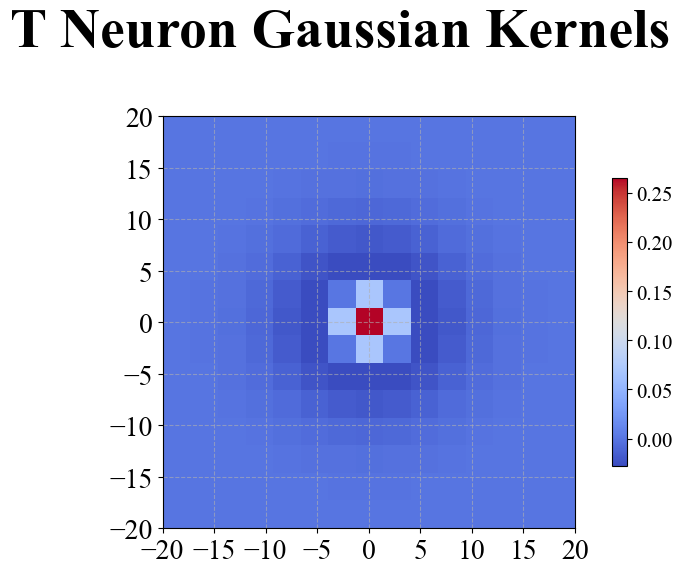

In [342]:
import numpy as np
import matplotlib.pyplot as plt
import os


def create_gaussian_kernel(sigma_x=1, sigma_y=1, angle=0, size=15):
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)

    # Rotate coordinates
    theta = np.radians(angle)
    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)

    # Create Gaussian kernel
    kernel = np.exp(-(x_rot**2 / ( sigma_x**2) + y_rot**2 / ( sigma_y**2)))
    kernel /= np.sum(kernel)  # Normalize to ensure the kernel sum is 1
    return kernel


# Generate kernels based on descriptions
kernels = {
    "T3": create_gaussian_kernel(sigma_x=1, sigma_y=1) - 1.5 * create_gaussian_kernel(sigma_x=3, sigma_y=3),
    # "T2": create_gaussian_kernel(sigma_x=1, sigma_y=1) - 1.5 * create_gaussian_kernel(sigma_x=3, sigma_y=3),
    # "T2a": create_gaussian_kernel(sigma_x=1, sigma_y=1) - 1 * create_gaussian_kernel(sigma_x=2, sigma_y=2),
    # "TmY3": create_gaussian_kernel(sigma_x=1, sigma_y=1),
    # "Y3": create_gaussian_kernel(sigma_x=1, sigma_y=1) - create_gaussian_kernel(sigma_x=3, sigma_y=3),
    # "TmY4": create_gaussian_kernel(sigma_x=1, sigma_y=0.5, angle=0),
    # "TmY9q": create_gaussian_kernel(sigma_x=1, sigma_y=0.5, angle=45),
    # "TmY9q⊥": create_gaussian_kernel(sigma_x=1, sigma_y=0.5, angle=135),
}

# Set up subplot grid
plot_gaussian_kernels(kernels, title="T Neuron Gaussian Kernels", n_rows=1, n_cols=1)


In [315]:
from scipy.ndimage import convolve
# 初始化结果字典来存储所有卷积结果
convolved_results = {kernel_name: {} for kernel_name in kernels.keys()}

# 对 L2 动画序列分别应用每个核进行卷积
for size, L2_images in L2_animations.items():
    timesteps, height, width = L2_images.shape
    for kernel_name, kernel in kernels.items():
        # 初始化卷积结果的数组
        convolved_results[kernel_name][size] = np.zeros_like(L2_images)

        # 对每个时间步应用卷积
        for t in range(timesteps):
            convolved_results[kernel_name][size][t] = convolve(L2_images[t], kernel, mode='constant', cval=0.0)
            
# 初始化结果字典来存储所有卷积结果
convolved_results1 = {kernel_name: {} for kernel_name in kernels.keys()}

# 对 L2 动画序列分别应用每个核进行卷积
for size, L1_images in L1_animations.items():
    timesteps, height, width = L1_images.shape
    for kernel_name, kernel in kernels.items():
        # 初始化卷积结果的数组
        convolved_results1[kernel_name][size] = np.zeros_like(L1_images)

        # 对每个时间步应用卷积
        for t in range(timesteps):
            convolved_results1[kernel_name][size][t] = convolve(L1_images[t], kernel, mode='constant', cval=0.0)


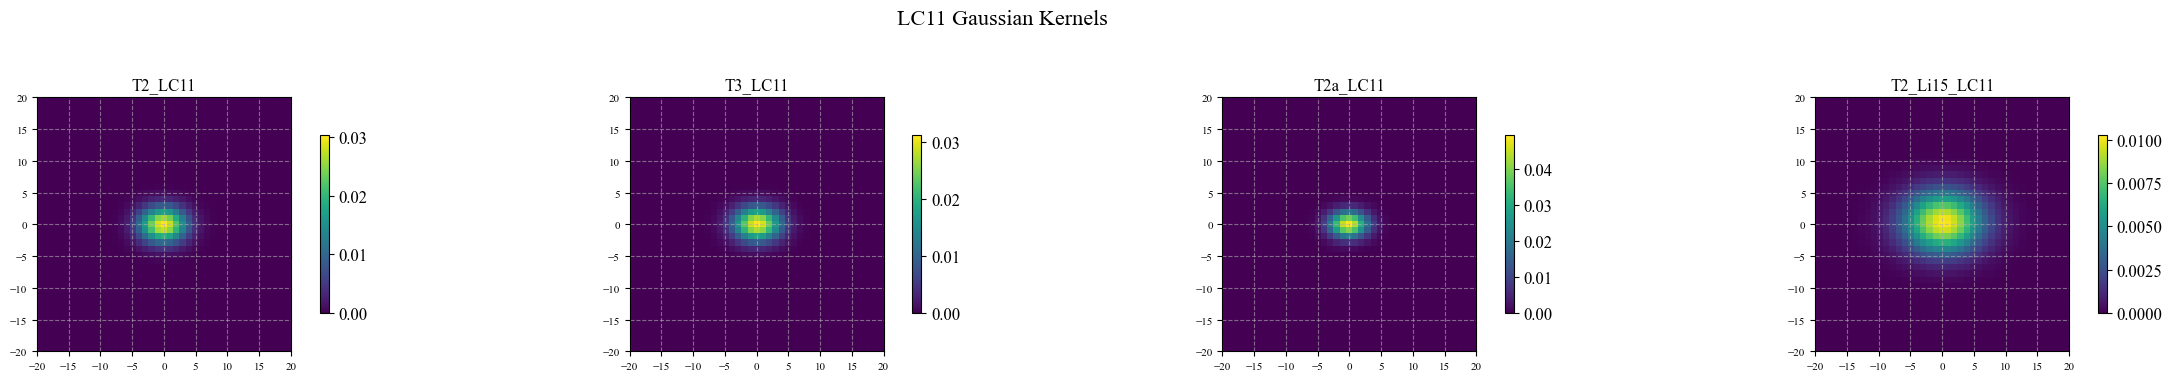

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import os

def create_gaussian_kernel_from_params(A, mu_x, mu_y, sigma_x, sigma_y, size=41):
    # Create a grid
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)
    
    # Generate Gaussian kernel
    kernel = A * np.exp(-(((x - mu_x)**2) / ( sigma_x**2) + ((y - mu_y)**2) / ( sigma_y**2)))
    kernel /= np.sum(kernel)  # Normalize
    return kernel

# Define parameters for Gaussian kernels
lc11_gaussian_params = {
    'T2_LC11': {'A': 0.016087013622013605, 'mu_x': -0.13760546727771442, 'mu_y': 0.11335302496547359, 
                'sigma_x': 3.716951856580259, 'sigma_y': 2.8203513069319524},
    'T3_LC11': {'A': 0.01642402741551777, 'mu_x': 0.058260160558346166, 'mu_y': 0.009257026035540109, 
                'sigma_x': 3.7609985770746204, 'sigma_y': 2.7205519467893393},
    'T2a_LC11': {'A': 0.025196046171514767, 'mu_x': -0.0733692598955412, 'mu_y': 0.04412542381516883, 
                 'sigma_x': 3.049755924731927, 'sigma_y': 2.117665735541721},
    'T2_Li15_LC11': {'A': 0.005603031553322903, 'mu_x': 0.22617863114548478, 'mu_y': -0.30347881030362206, 
                     'sigma_x': 6.342110203546551, 'sigma_y': 4.871036470984641}
}

# Generate kernels
LC11_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc11_gaussian_params.items()}

# Plot the kernels
plot_gaussian_kernels(LC11_kernels, title="LC11 Gaussian Kernels", n_rows=1, n_cols=4)

In [317]:
LC11_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC11_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.26 * np.sum((convolved_results['T3'][size][t] + convolved_results1['T3'][size][t]) * LC11_kernels['T3_LC11']) +
            0.08 * np.sum((convolved_results['T2'][size][t] + convolved_results1['T2'][size][t]) * LC11_kernels['T2_LC11']) -
            0.08* np.sum((convolved_results['T2'][size][t] + convolved_results1['T2'][size][t]) * LC11_kernels['T2_Li15_LC11'])
        )
        LC11_results[size][t] = weighted_sum


In [318]:
# LC4 Gaussian parameters
lc4_gaussian_params = {
    'T2_LC4': {'A': 0.018513809048837246, 'mu_x': 0.054096311785315605, 'mu_y': 0.008523544222943595, 
               'sigma_x': 3.4807361906839693, 'sigma_y': 2.616484464259377},
    'Tm2_LC4': {'A': 0.02190903676319083, 'mu_x': -0.05394101305364264, 'mu_y': 0.11412399118711397, 
                'sigma_x': 3.263629530779502, 'sigma_y': 2.4430368713529083},
    'Tm4_LC4': {'A': 0.018667265111389834, 'mu_x': 0.08794526088371826, 'mu_y': 0.12160987449984162, 
                'sigma_x': 3.519932580619196, 'sigma_y': 2.614902028364438},
    'Tm2_Li22_LC4': {'A': 0.0045380649031923235, 'mu_x': -0.10023876174833643, 'mu_y': 0.12002150844340005, 
                     'sigma_x': 7.750228389083664, 'sigma_y': 4.980194060026573}
}

# Generate Gaussian kernels for LC4
LC4_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc4_gaussian_params.items()}

In [319]:
LC4_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC4_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.23 * np.sum((convolved_results['TmY3'][size][t] + convolved_results1['TmY3'][size][t]) * LC4_kernels['T2_LC4']) +
            0.08 * np.sum((Tm2_animations[size][t]) * LC4_kernels['Tm2_LC4']) +
            0.08 * np.sum((Tm4_animations[size][t]) * LC4_kernels['Tm4_LC4']) +
            0.18 * np.sum((convolved_results['T2'][size][t] + convolved_results1['T2'][size][t]) * LC4_kernels['T2_LC4']) -
            0.07 * np.sum((Tm2_animations[size][t]) * LC4_kernels['Tm2_Li22_LC4']) 
        )
        LC4_results[size][t] = weighted_sum

In [320]:

# LC12 Gaussian parameters
lc12_gaussian_params = {
    'T2_LC12': {'A': 0.06641826386396342, 'mu_x': 0.039024688757947894, 'mu_y': 0.10262580798423097, 
                'sigma_x': 1.7270439633049106, 'sigma_y': 1.4163365759157482},
    'Tm4_LC12': {'A': 0.0784081691606213, 'mu_x': 0.0015930201222432373, 'mu_y': 0.08118234959358771, 
                 'sigma_x': 1.5754422127561045, 'sigma_y': 1.348221467689174},
    'Tm3_LC12': {'A': 0.06853246415343084, 'mu_x': -0.03152815295703715, 'mu_y': 0.07658889963369184, 
                 'sigma_x': 1.6898701338158273, 'sigma_y': 1.4439000865480427},
    'T3_LC12': {'A': 0.12845784326194765, 'mu_x': 0.015225526024539403, 'mu_y': 0.10355430407635456, 
                'sigma_x': 1.1269415660743514, 'sigma_y': 1.1326247072051248},
    'T3_Li17_LC12': {'A': 0.014546699134548226, 'mu_x': -0.004596357869558654, 'mu_y': -0.03729625251632292, 
                     'sigma_x': 3.8154355313057735, 'sigma_y': 3.0820594144848332}
}

# Generate Gaussian kernels for LC12
LC12_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc12_gaussian_params.items()}

In [321]:
LC12_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC12_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.07 * np.sum((convolved_results['TmY3'][size][t]+convolved_results1['TmY3'][size][t]) * LC12_kernels['T2_LC12']) +
            0.13 * np.sum((Tm4_animations[size][t]) * LC12_kernels['Tm4_LC12']) +
            0.22 * np.sum((Tm3_animations[size][t]) * LC12_kernels['Tm3_LC12']) +
            0.04 * np.sum((convolved_results['T3'][size][t]+convolved_results1['T3'][size][t]) * LC12_kernels['T3_LC12']) +
            0.09 * np.sum((convolved_results['T2'][size][t]+convolved_results1['T2'][size][t]) * LC12_kernels['T2_LC12']) -
            0.08 * np.sum((convolved_results['T3'][size][t]+convolved_results1['T3'][size][t]) * LC12_kernels['T3_Li17_LC12'])
        )
        LC12_results[size][t] = weighted_sum

In [322]:
# LC18 Gaussian parameters
lc18_gaussian_params = {
    'T2_LC18': {'A': 0.02713970800096853, 'mu_x': -0.07179159144228903, 'mu_y': 0.018729988542747496, 
                'sigma_x': 2.795021455146342, 'sigma_y': 2.2096976215124475},
    'T3_Li17_LC18': {'A': 0.014359611113604268, 'mu_x': 0.029305314400791878, 'mu_y': -0.03595774162119623, 
                     'sigma_x': 3.848402648694555, 'sigma_y': 3.100030786420205}
}

# Generate Gaussian kernels for LC18
LC18_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc18_gaussian_params.items()}

In [323]:
LC18_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC18_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.43 * np.sum((convolved_results['T2'][size][t]+convolved_results1['T2'][size][t]) * LC18_kernels['T2_LC18']) -
            0.17 * np.sum((convolved_results['T3'][size][t]+convolved_results1['T3'][size][t]) * LC18_kernels['T3_Li17_LC18'])
        )
        LC18_results[size][t] = weighted_sum

In [324]:
# LC15 Gaussian parameters
lc15_gaussian_params = {
    'TmY4_LC15': {'A': 0.04409888147861526, 'mu_x': -0.007994320007836897, 'mu_y': 0.023466689434117546, 
                  'sigma_x': 1.644234542649545, 'sigma_y': 2.306385805051322},
    'TmY9q_LC15': {'A': 0.03164224747226373, 'mu_x': -0.2027214526931886, 'mu_y': -0.18763275823748118, 
                   'sigma_x': 2.011376069102185, 'sigma_y': 2.5669475036009515},
    'TmY9q⊥_LC15': {'A': 0.0369598648345647, 'mu_x': -0.16755212113704124, 'mu_y': -0.002995066618808462, 
                   'sigma_x': 2.4895092836187076, 'sigma_y': 1.783461606807423},
    'TmY4': {'A': 0.40058228742690793, 'mu_x': 0.061147344408554474, 'mu_y': -0.016076982225191723, 
             'sigma_x': 2.6396202022987993, 'sigma_y': 1.1852793578943386},
    'TmY9q': {'A': 0.2208996648108997, 'mu_x': -0.15525599023951164, 'mu_y': -0.10216746179102933, 
              'sigma_x': 2.5228478460533723, 'sigma_y': 2.074968366084065},
    'TmY9q-': {'A': 0.34078322131601213, 'mu_x': -0.0966083919091684, 'mu_y': -0.0469801526998648, 
               'sigma_x': 1.6625405398658457, 'sigma_y': 2.0712466503470024},
    'Tm4_Li31_LC15': {'A': 0.0012283486192213435, 'mu_x': -2.3172045459397936, 'mu_y': -1.0462629049505578, 
                      'sigma_x': 25.84198328868638, 'sigma_y': 9.554889155389219},
    'TmY4_Li27_LC15': {'A': 0.0039341106406771895, 'mu_x': -1.9935061224108113, 'mu_y': 0.06916555393420326, 
                       'sigma_x': 6.664686717850694, 'sigma_y': 6.470826461927718},
    'TmY9q_Li27_LC15': {'A': 0.0029554711322933203, 'mu_x': -3.638558879559575, 'mu_y': -0.8259048282889158, 
                        'sigma_x': 8.557818486952835, 'sigma_y': 7.1371115446711855},
    'TmY9q⊥_Li27_LC15': {'A': 0.0029086244057321057, 'mu_x': -1.3919424325550047, 'mu_y': -1.0749580507482217, 
                        'sigma_x': 8.768053373958809, 'sigma_y': 7.185196630919564}
}

# Generate Gaussian kernels for LC15
LC15_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc15_gaussian_params.items()}

In [325]:
LC15_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC15_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.15 * np.sum((convolved_results['TmY4'][size][t]+convolved_results1['TmY4'][size][t]) * LC15_kernels['TmY4_LC15']) +
            0.12 * np.sum((convolved_results['TmY9q⊥'][size][t]+convolved_results1['TmY9q⊥'][size][t]) * LC15_kernels['TmY9q⊥_LC15']) +
            0.09 * np.sum((convolved_results['TmY9q'][size][t]+convolved_results1['TmY9q'][size][t]) * LC15_kernels['TmY9q_LC15']) -
            0.13 * 0.2 * np.sum((convolved_results['TmY4'][size][t]+convolved_results1['TmY4'][size][t]) * LC15_kernels['TmY4_Li27_LC15']) -
            0.13 * 0.2 * np.sum((convolved_results['TmY9q⊥'][size][t]+convolved_results1['TmY9q⊥'][size][t]) * LC15_kernels['TmY9q⊥_Li27_LC15']) -
            0.13 * 0.14 * np.sum((convolved_results['TmY9q'][size][t]+convolved_results1['TmY9q'][size][t]) * LC15_kernels['TmY9q_Li27_LC15']) -
            0.05 * np.sum((Tm4_animations[size][t]) * LC15_kernels['Tm4_Li31_LC15'])
        )
        LC15_results[size][t] = weighted_sum

In [326]:
lc21_gaussian_params = {
    'T3_LC21': {'A': 0.09646828840280255, 'mu_x': 0.034449208808531404, 'mu_y': 0.0515986416703293, 
                  'sigma_x': 1.367642927650473, 'sigma_y': 1.115522701451049},
}

# Generate Gaussian kernels for LC21
LC21_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc21_gaussian_params.items()}

In [327]:
LC21_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC21_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.21 * np.sum((convolved_results['T3'][size][t]+convolved_results1['T3'][size][t]) * LC21_kernels['T3_LC21'])
        )
        LC21_results[size][t] = weighted_sum

In [328]:
import numpy as np
import matplotlib.pyplot as plt

def create_directional_kernels(sigma, size, filter_order=2):
    """
    Create four directional Gaussian kernels centered at up, down, left, and right.
    """
    degs_x, degs_y = np.meshgrid(
        np.arange(-size, size + 1, 1), np.arange(-size, size + 1, 1)
    )
    
    up_kernel = np.exp(-((degs_x ** filter_order + (degs_y + size // 2) ** filter_order) / (2 * sigma ** filter_order)))
    down_kernel = np.exp(-((degs_x ** filter_order + (degs_y - size // 2) ** filter_order) / (2 * sigma ** filter_order)))
    left_kernel = np.exp(-(((degs_x + size // 2) ** filter_order + degs_y ** filter_order) / (2 * sigma ** filter_order)))
    right_kernel = np.exp(-(((degs_x - size // 2) ** filter_order + degs_y ** filter_order) / (2 * sigma ** filter_order)))
    
    up_kernel /= np.sum(up_kernel)
    down_kernel /= np.sum(down_kernel)
    left_kernel /= np.sum(left_kernel)
    right_kernel /= np.sum(right_kernel)

    return up_kernel, down_kernel, left_kernel, right_kernel

sigma = 0.5 
size = 2     
filter_order = 2 

up_kernel, down_kernel, left_kernel, right_kernel = create_directional_kernels(sigma, size, filter_order)


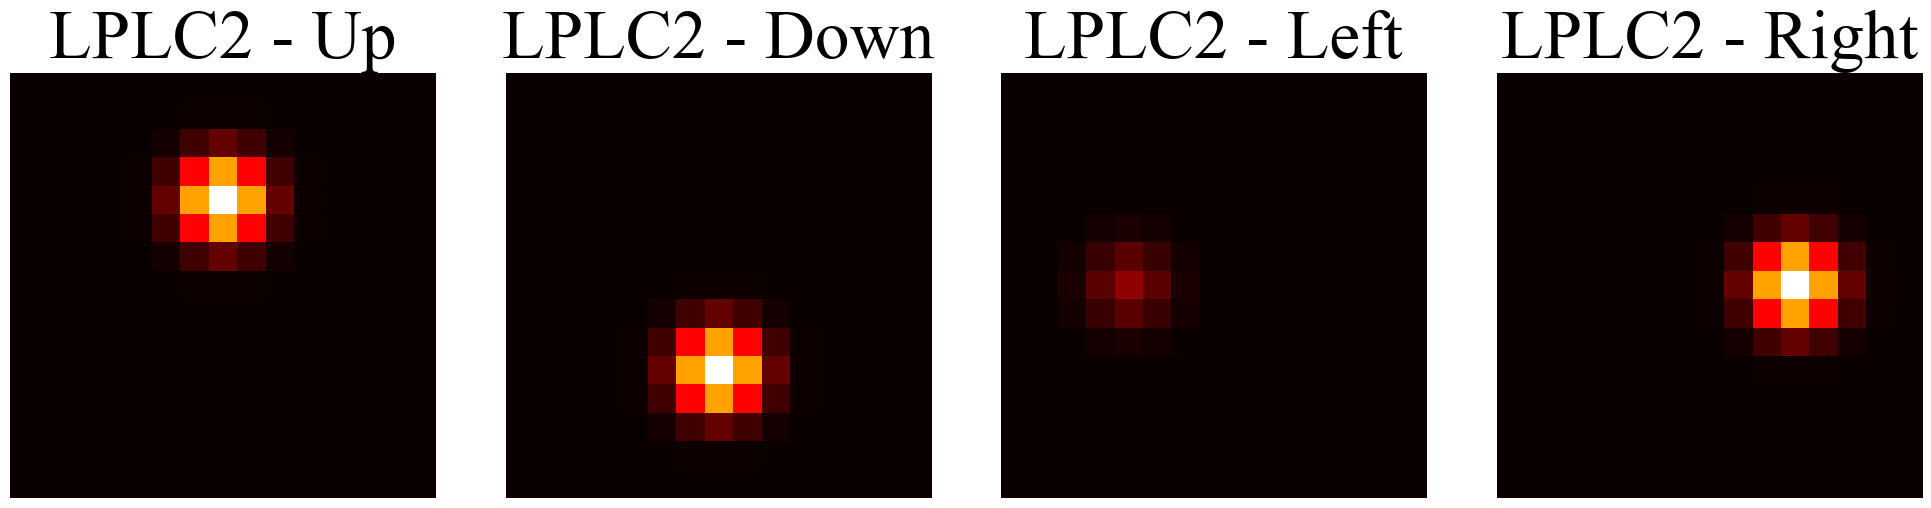

In [329]:
from scipy.ndimage import convolve

assert Tm9_animations.keys() == Tm1_animations.keys(), "Keys in Tm9_animations and Tm1_animations must match."

T5_up = {
    size: np.array([convolve(frame, up_kernel, mode='constant') for frame in Tm9_animations[size]]) * Tm1_animations[size]
    for size in Tm9_animations.keys()
}

T5_down = {
    size: np.array([convolve(frame, down_kernel, mode='constant') for frame in Tm9_animations[size]]) * Tm1_animations[size]
    for size in Tm9_animations.keys()
}

T5_left = {
    size: np.array([convolve(frame, left_kernel, mode='constant') for frame in Tm9_animations[size]]) * Tm1_animations[size]
    for size in Tm9_animations.keys()
}

T5_right = {
    size: np.array([convolve(frame, right_kernel, mode='constant') for frame in Tm9_animations[size]]) * Tm1_animations[size]
    for size in Tm9_animations.keys()
}

def create_LPLC2_directional_kernels(sigma, size, filter_order=2, compile=0.2):
    """
    Create four directional Gaussian kernels centered at up, down, left, and right for LPLC2 upstream.
    """
    degs_x, degs_y = np.meshgrid(
        np.arange(-size, size + 1, 1), np.arange(-size, size + 1, 1)
    )
    
    up_kernel = np.exp(-((degs_x ** filter_order + (degs_y + size // 2) ** filter_order) / (2 * sigma ** filter_order)))
    down_kernel = np.exp(-((degs_x ** filter_order + (degs_y - size // 2) ** filter_order) / (2 * sigma ** filter_order)))
    left_kernel = np.exp(-(((degs_x + size // 2) ** filter_order + degs_y ** filter_order) / (2 * sigma ** filter_order)))
    right_kernel = np.exp(-(((degs_x - size // 2) ** filter_order + degs_y ** filter_order) / (2 * sigma ** filter_order)))
    
    up_kernel /= np.sum(up_kernel)
    down_kernel /= np.sum(down_kernel)
    left_kernel /= np.sum(left_kernel)
    right_kernel /= np.sum(right_kernel)

    return up_kernel, down_kernel, left_kernel*compile, right_kernel

sigma = 1      
size = 7       
filter_order = 2

up_kernel, down_kernel, left_kernel, right_kernel = create_LPLC2_directional_kernels(sigma, size, filter_order)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, kernel, title in zip(axes, [up_kernel, down_kernel, left_kernel, right_kernel], 
                             ["LPLC2 - Up", "LPLC2 - Down", 
                              "LPLC2 - Left", "LPLC2 - Right"]):
    cax = ax.imshow(kernel, cmap="hot", interpolation="nearest", vmin=0, vmax=np.max([up_kernel, down_kernel, left_kernel, right_kernel]))
    ax.set_title(title, fontsize=50)
    ax.axis("off")

plt.tight_layout()
plt.show()


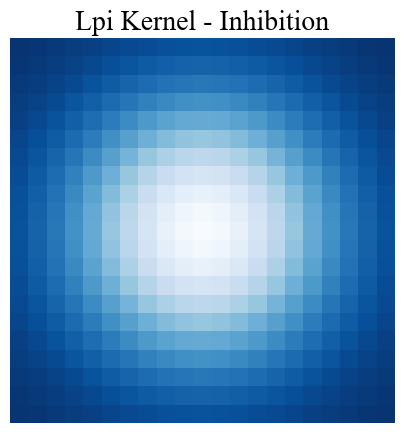

In [330]:
import numpy as np
import matplotlib.pyplot as plt

def create_Lpi_kernel(radius, sigma):
    """
    Creates the Lpi (center-surround inhibition) kernel with strong center inhibition that weakens towards the edges.
    
    Parameters:
        radius (int): Radius of the kernel.
        sigma (float): Standard deviation of the Gaussian, controls spread of inhibition.
        
    Returns:
        np.ndarray: The Lpi kernel with center inhibition.
    """
    # Create a grid of (x, y) coordinates
    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    
    # Gaussian for inhibition centered at (0, 0), with negative values
    Lpi_kernel = -np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # Normalize the kernel to keep values in a controlled range
    Lpi_kernel /= np.abs(Lpi_kernel).sum()  # Normalization based on absolute sum

    return Lpi_kernel

# Parameters for the Lpi kernel
radius = 10
sigma = 5  # Controls how quickly inhibition weakens from the center

# Generate the Lpi kernel
Lpi_kernel = create_Lpi_kernel(radius, sigma)

# Visualize the Lpi kernel
plt.figure(figsize=(5, 5))
plt.imshow(Lpi_kernel, cmap="Blues", interpolation="nearest", vmin=-np.max(abs(Lpi_kernel)), vmax=0)
plt.title("Lpi Kernel - Inhibition", fontsize=20, fontname="Times New Roman")
plt.axis("off")
plt.show()


In [331]:
from scipy.ndimage import convolve
import numpy as np

LPLC2_results = {}

for size in T5_up.keys():  
    timesteps, height, width = T5_up[size].shape
    
    LPLC2_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        up_sum = np.sum(convolve(T5_up[size][t], up_kernel, mode='constant'))
        down_sum = np.sum(convolve(T5_down[size][t], down_kernel, mode='constant'))
        left_sum = np.sum(convolve(T5_left[size][t], left_kernel, mode='constant'))
        right_sum = np.sum(convolve(T5_right[size][t], right_kernel, mode='constant'))
        inhibit_sum = np.sum(convolve(T5_down[size][t], Lpi_kernel, mode='constant'))

        weighted_sum = (
            0.04 * up_sum +
            0.04 * down_sum +
            0.04 * left_sum +
            0.04 * right_sum +
            0.01 * inhibit_sum
        )
        LPLC2_results[size][t] = weighted_sum


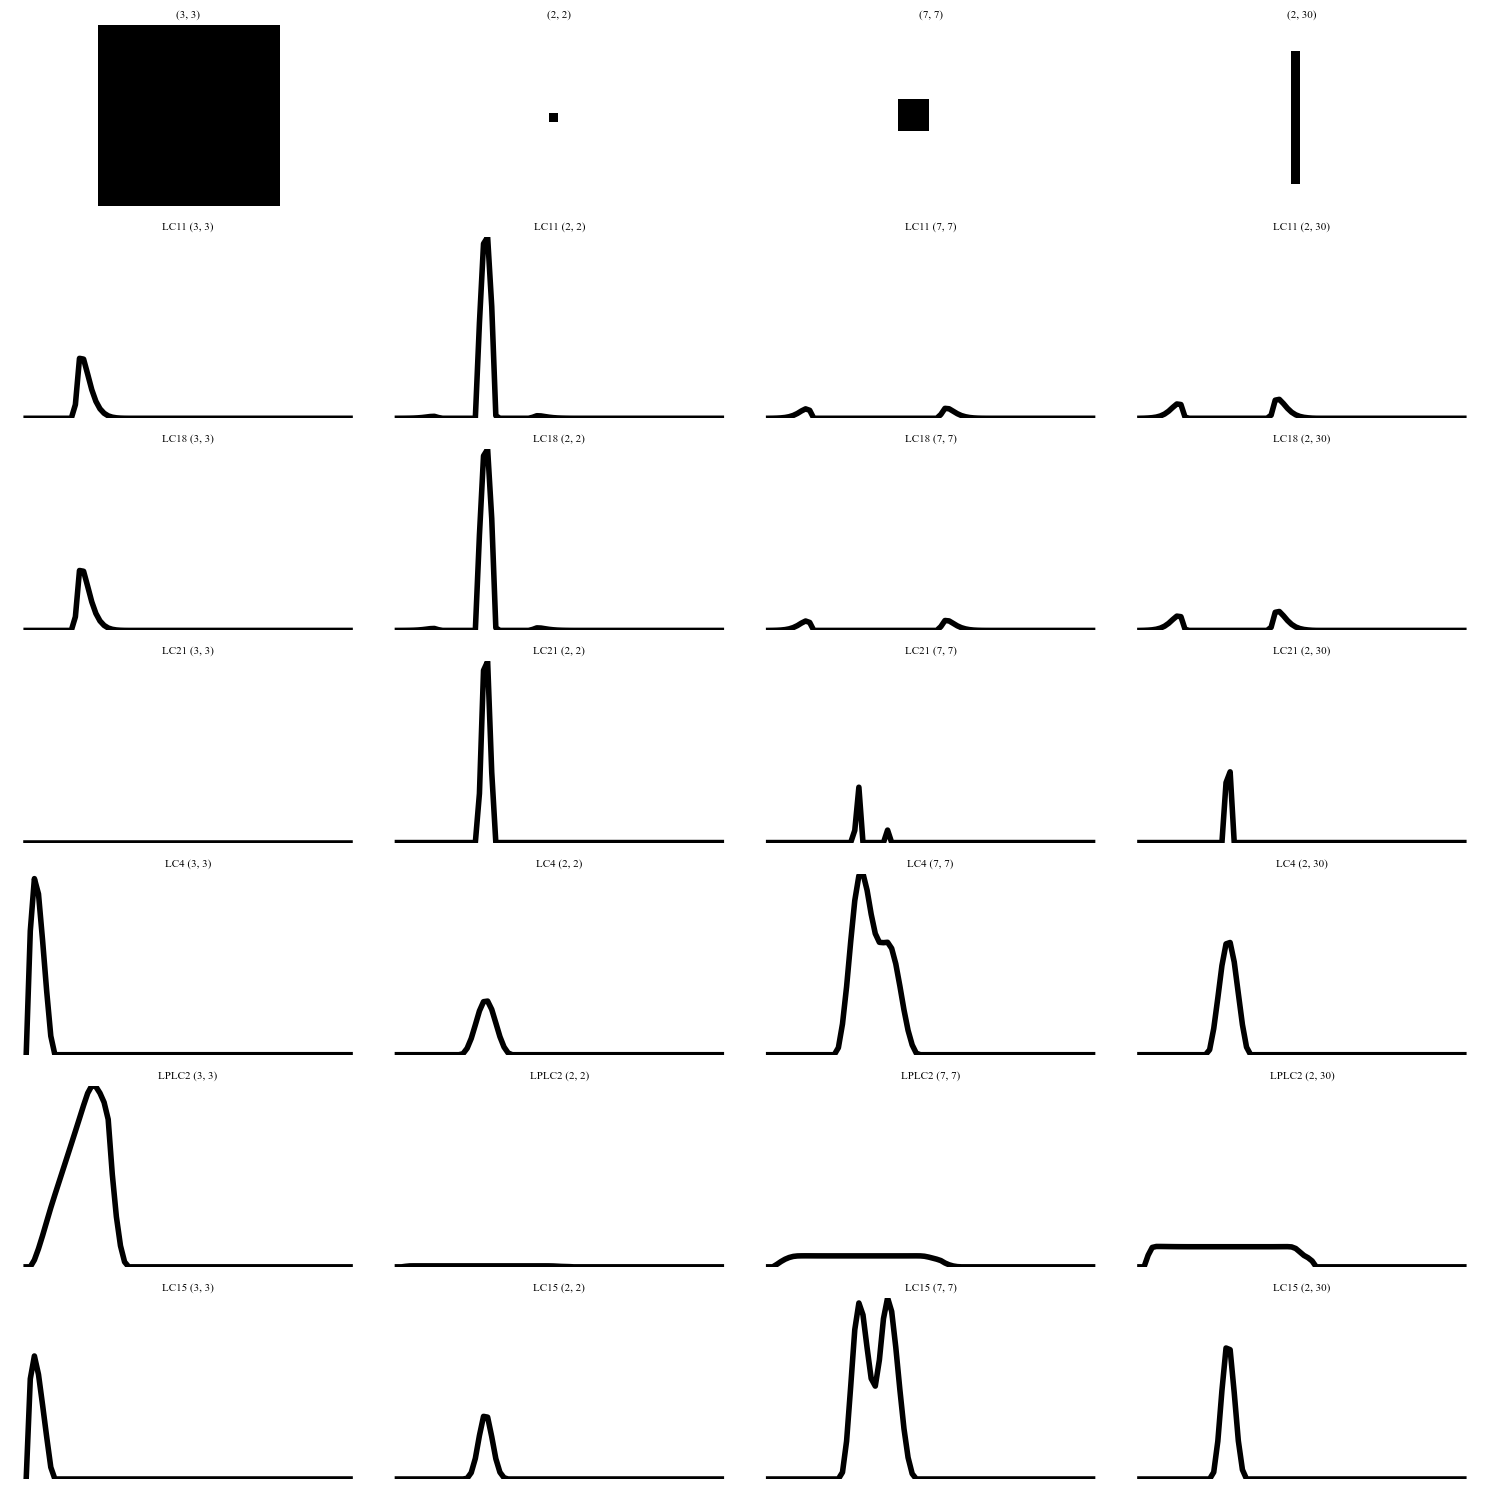

In [332]:
LC_results_dict = {
    "LC11": LC11_results,
    "LC18": LC11_results,
    "LC21": LC21_results,
    "LC4": LC4_results,
    "LPLC2": LPLC2_results,
    "LC15": LC15_results,
}
plot_all_animations_with_lc_results(all_animations, LC_results_dict, t=20, figsize=(15, 15), ncols=4)